In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import folium

Lectura de archivo CSV. En el archivo CSV tiene las fechas como obj, necesitamos cambiarlas a datetime.

In [104]:
link = (r"C:\Users\migue\Desktop\Proyecto BEDU\Generacion_Bruta_SIE.csv")
df = pd.read_csv(link)

df[['fecha']] = pd.to_datetime(df['fecha'])

df.head()


,fecha,bca,bcs,sin
0,2010-01-01,873193.999,146750.596,17290950.83
1,2010-02-01,793243.355,134343.163,15602656.31
2,2010-03-01,871591.088,154825.632,18255692.77
3,2010-04-01,785727.001,157132.166,18585459.93
4,2010-05-01,870490.271,174237.376,20768787.08


## Análisis Exploratorio de Datos (EDA)

En este paso revisaremos nuestros datos, como se comportan graficamente para tener un contexto más claro.

In [105]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   146 non-null    datetime64[ns]
 1   bca     146 non-null    float64       
 2   bcs     146 non-null    float64       
 3   sin     146 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 4.7 KB


,bca,bcs,sin
count,1.460000e+02,146.000000,1.460000e+02
mean,9.979682e+05,199044.687214,1.965117e+07
std,1.747548e+05,36304.176070,2.297957e+06
min,7.092862e+05,125861.119000,1.449325e+07
25%,8.654446e+05,171817.357500,1.795213e+07
50%,9.342025e+05,190254.320900,1.985295e+07
75%,1.126285e+06,222936.348000,2.175807e+07
max,1.423024e+06,310344.000000,2.344321e+07


In [106]:
import plotly.express as px

fig = px.line(df, x='fecha', y=['bca', 'bcs', 'sin'], title='Generación Bruta MWh BCA')
        
fig.update_xaxes(rangeslider_visible=True)
fig.show()

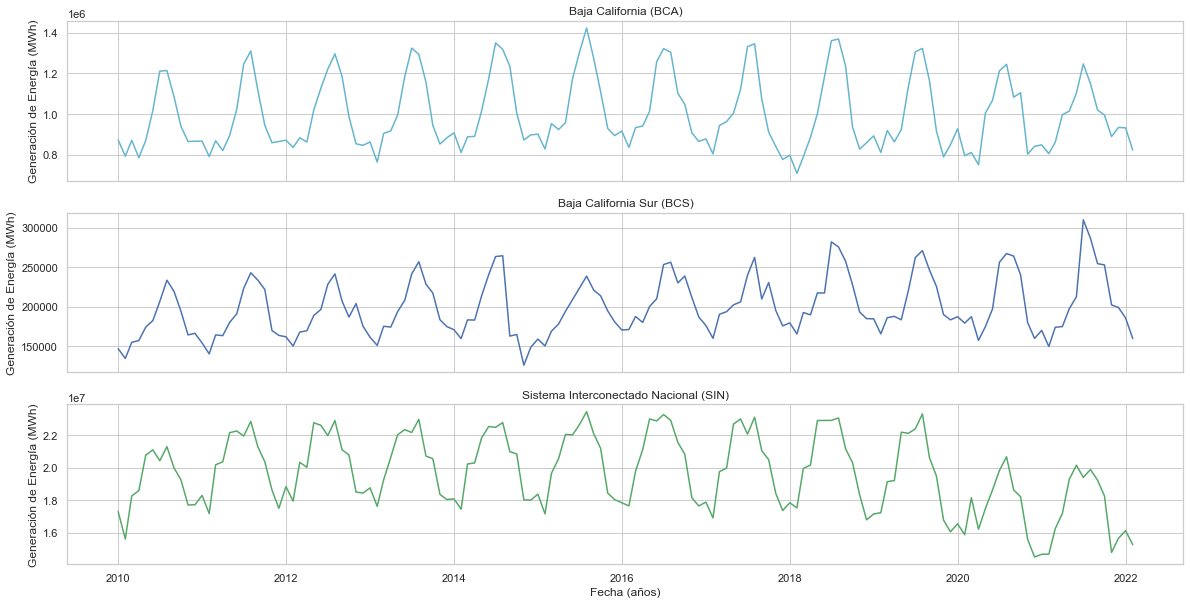

In [107]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, sharex=True,  figsize=(20,10))

#BCA
ax[0].plot(df['fecha'], 
        df['bca'], color = 'c')

ax[1].plot(df['fecha'], 
        df['bcs'], color = 'b')

ax[2].plot(df['fecha'], 
        df['sin'], color = 'g')

ax[0].set_title('Baja California (BCA)')
ax[0].set_ylabel('Generación de Energía (MWh)')

ax[1].set_title('Baja California Sur (BCS)')
ax[1].set_ylabel('Generación de Energía (MWh)')

ax[2].set_title('Sistema Interconectado Nacional (SIN)')
ax[2].set_ylabel('Generación de Energía (MWh)')
ax[2].set_xlabel('Fecha (años)')

plt.show()

In [108]:
import plotly.express as px
import requests
repo_url = 'https://raw.githubusercontent.com/angelnmara/geojson/master/mexicoHigh.json'
data_estado = pd.read_csv(r'C:\Users\migue\Desktop\Proyecto BEDU\Generacion_Bruta_SIE_Anual.csv')
mx_regions_geo = requests.get(repo_url).json()

fig = px.choropleth(data_frame=data_estado,
                    geojson=mx_regions_geo,
                    locations='estado',
                    featureidkey='properties.name',
                    color='2021',
                    color_continuous_scale= 'Darkmint'
                    )

fig.update_geos(showcountries=True, showcoastlines=True, showland=True, fitbounds='locations')

fig.update_layout(
    title_text = 'Generación Bruta por Entidad Federativa (MWh)',
    font=dict(
        family='Ubuntu',
        size=18,
        color='#7f7f7f'
    ),
    annotations = [dict(
        x=0.3,
        y=0.1,
        xref='paper',
        yref='paper',
        text='Fuente: <a href= "https://sie.energia.gob.mx/bdiController.do?action=cuadro&subAction=applyOptions">\
        SENER </a>',
        showarrow = False
    )]
)

fig.show()



## Análisis de Regresión Lineal para Series de Tiempo.

Esta función transforma un dataset a un serie de tiempo: toma N valores y el N+1 lo vuelve una salida esperada.

In [109]:
def transformarSerieADataset(serie, elementosPorMuestra):
    dataset = None
    salidasDataset = None
    for counter in range (len(serie)-elementosPorMuestra-1):        
        muestra = np.array([serie[counter:counter+elementosPorMuestra]])        
        salida = np.array([serie[counter+elementosPorMuestra]])
        if dataset is None:
            dataset = muestra
        else:
            dataset = np.append(dataset,muestra,axis = 0)
        if salidasDataset is None:
            salidasDataset = salida    
        else:        
            salidasDataset = np.append(salidasDataset,salida)
    return dataset, salidasDataset

Lo convertimos a numpy array (no obligatorio, pero si un poco mas rápido en su procesamiento)

In [110]:
serie = df['bca']
serie.to_numpy()

array([ 873193.999 ,  793243.355 ,  871591.088 ,  785727.001 ,
        870490.271 , 1018504.823 , 1210946.175 , 1214077.891 ,
       1084907.635 ,  940333.298 ,  865317.36  ,  866979.811 ,
        866958.701 ,  791695.35  ,  869045.354 ,  821249.244 ,
        894858.889 , 1024233.359 , 1245806.02  , 1309745.01  ,
       1114674.112 ,  944890.923 ,  859450.862 ,  865826.2   ,
        871969.673 ,  836216.079 ,  883788.375 ,  863017.96  ,
       1019960.954 , 1127504.58  , 1220960.52  , 1295617.4   ,
       1185515.569 ,  988289.32  ,  854114.858 ,  846762.114 ,
        863321.265 ,  764320.461 ,  904909.251 ,  917783.837 ,
        996449.072 , 1185100.284 , 1324097.119 , 1293681.368 ,
       1157205.892 ,  944845.517 ,  852777.997 ,  883771.639 ,
        907941.756 ,  811641.005 ,  888584.015 ,  890763.824 ,
       1014564.89  , 1173598.469 , 1350004.285 , 1317867.124 ,
       1234712.844 , 1005710.267 ,  873184.215 ,  897789.32  ,
        901812.098 ,  828750.999 ,  953253.733 ,  92441

Convertimos nuestro dataset a un arreglo numpy y aplicamos nuestra funcion de dataset a serie.

In [111]:
X, Y = transformarSerieADataset(serie, elementosPorMuestra=10)
print(X)

[[ 873193.999  793243.355  871591.088 ... 1214077.891 1084907.635
   940333.298]
 [ 793243.355  871591.088  785727.001 ... 1084907.635  940333.298
   865317.36 ]
 [ 871591.088  785727.001  870490.271 ...  940333.298  865317.36
   866979.811]
 ...
 [ 848838.     805857.     862664.    ... 1149805.    1020363.
   995426.   ]
 [ 805857.     862664.     996947.    ... 1020363.     995426.
   889775.   ]
 [ 862664.     996947.    1014973.    ...  995426.     889775.
   934549.   ]]


Aqui vamos a dividir los datos en Train y Test y entrenaremos un regresor lineal para obtener lo mejor que pueda una predicción.

In [112]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, shuffle = False, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(81, 10)
(54, 10)
(81,)
(54,)


In [113]:
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

y_train_predict = lin_model.predict(X_train)
MSE = mean_squared_error(Y_train,y_train_predict)
print("Entrenamiento: MSE ="+str(MSE))

y_test_predict = lin_model.predict(X_test)
MSE = (mean_squared_error(Y_test, y_test_predict))
print("Pruebas: MSE ="+str(MSE))

Entrenamiento: MSE =4206078552.193061
Pruebas: MSE =6715715461.903146


In [114]:
df_predicciones = pd.DataFrame({'valor real':Y_test, 'prediccion':y_test_predict, 'diferencia':Y_test-y_test_predict})
df_predicciones = df_predicciones.reset_index(drop = True)
df_predicciones.head(10)

,valor real,prediccion,diferencia
0,1.345084e+06,1.321476e+06,23607.157190
1,1.073796e+06,1.222773e+06,-148976.995731
2,9.123681e+05,9.709733e+05,-58605.242203
3,8.415327e+05,8.112011e+05,30331.570442
4,7.768844e+05,7.922197e+05,-15335.355388
5,7.985164e+05,8.488553e+05,-50338.947519
6,7.092862e+05,8.770960e+05,-167809.777115
7,7.907403e+05,7.711244e+05,19615.839752
8,8.860515e+05,8.692243e+05,16827.219341
9,1.001922e+06,1.095360e+06,-93437.694912


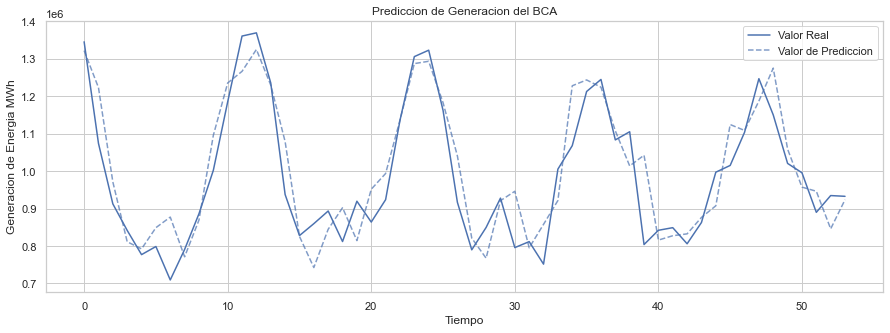

In [115]:
fig, ax = plt.subplots(figsize=(15,5))

plt.plot(df_predicciones['valor real'], label = 'Valor Real', color = 'b')
plt.plot(df_predicciones['prediccion'], label = 'Valor de Prediccion', color = 'b', alpha = 0.7, linestyle='--')

plt.title('Prediccion de Generacion del BCA')
plt.xlabel('Tiempo')
plt.ylabel('Generacion de Energia MWh')
plt.legend()
plt.show()

El modelo de regresión lineal resultó muy bueno, pero se notan algunas zonas que estan levemente desfasadas de los datos originales.

## Regresión Polinomial

Igual que en el análisis anterior, llamamos al modelo, lo entrenamos y vemos los resultados.

In [116]:
poly_model = LinearRegression()
poly = PolynomialFeatures(degree=5)

Xpolytrain = poly.fit_transform(X_train)
Xpolytest = poly.fit_transform(X_test)

poly_model.fit(Xpolytrain, Y_train)
y_train_predict = poly_model.predict(Xpolytrain)

MSE = mean_squared_error(Y_train,y_train_predict)
print("Entrenamiento Grado = 5: MSE ="+str(MSE))

y_test_predict = poly_model.predict(Xpolytest)
MSE = (mean_squared_error(Y_test, y_test_predict))
print("Pruebas Grado = 5: MSE ="+str(MSE))




Entrenamiento Grado = 5: MSE =9.742928504012872e-18
Pruebas Grado = 5: MSE =30779924145.388336


In [117]:
df_predicciones_poly = pd.DataFrame({'valor real':Y_test, 'prediccion':y_test_predict, 'diferencia':Y_test-y_test_predict})
df_predicciones_poly = df_predicciones_poly.reset_index(drop = True)
df_predicciones_poly.head(10)


,valor real,prediccion,diferencia
0,1.345084e+06,1.273475e+06,71608.498870
1,1.073796e+06,1.209171e+06,-135374.242000
2,9.123681e+05,8.036550e+05,108713.050674
3,8.415327e+05,6.748013e+05,166731.358947
4,7.768844e+05,9.030218e+05,-126137.429380
5,7.985164e+05,8.511598e+05,-52643.403526
6,7.092862e+05,9.554816e+05,-246195.365020
7,7.907403e+05,1.016234e+06,-225493.284634
8,8.860515e+05,1.151652e+06,-265600.324055
9,1.001922e+06,1.339258e+06,-337336.124479


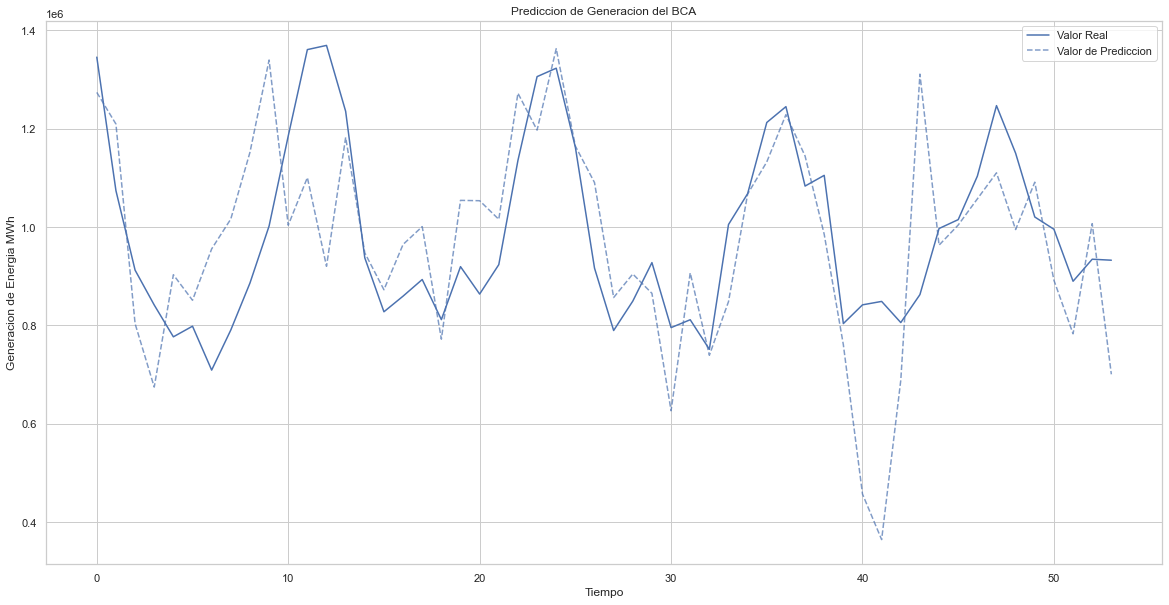

In [118]:
fig, ax = plt.subplots(figsize=(20,10))

plt.plot(df_predicciones_poly['valor real'], label = 'Valor Real', color = 'b')
plt.plot(df_predicciones_poly['prediccion'], label = 'Valor de Prediccion', color = 'b', alpha = 0.7, linestyle='--')

plt.title('Prediccion de Generacion del BCA')
plt.xlabel('Tiempo')
plt.ylabel('Generacion de Energia MWh')
plt.legend()
plt.show()


Podemos observar que aun haciendo una regresión polinomial el modelo es muy sensible a los picos que presentan los datos. La mejor opción es implementar otro modelo que se ajuste con mayor precisión.

## Implementación de modelo SARIMAX para Series de Tiempo

## SISTEMA ELECTRICO DE BAJA CALIFORNIA (BCA).
# Predicción de Generación Eléctrica


Lo primero que tenemos que hacer para implementar modelos de series de tiempo es asegurar que nuestro dataset no contenga valores nulos.

In [119]:
df.isna().sum()

fecha    0
bca      0
bcs      0
sin      0
dtype: int64

Hacemos un .describe() para ver un panorama general de la información de nuestros datos.

In [120]:
df.describe()

,bca,bcs,sin
count,1.460000e+02,146.000000,1.460000e+02
mean,9.979682e+05,199044.687214,1.965117e+07
std,1.747548e+05,36304.176070,2.297957e+06
min,7.092862e+05,125861.119000,1.449325e+07
25%,8.654446e+05,171817.357500,1.795213e+07
50%,9.342025e+05,190254.320900,1.985295e+07
75%,1.126285e+06,222936.348000,2.175807e+07
max,1.423024e+06,310344.000000,2.344321e+07


Hacemos nuestra limpieza del dataset anterior eliminando las columnas que no necesitamos (este paso lo repetiremos posteriormente para el BCS y el SIN) con fecha como index.

In [121]:
df_bca = df.drop(columns = ['sin', 'bcs'])
df_bca.set_index(df_bca['fecha'], inplace=True)
df_bca.drop(columns='fecha', inplace=True)
df_bca.head()

,bca
fecha,
2010-01-01,873193.999
2010-02-01,793243.355
2010-03-01,871591.088
2010-04-01,785727.001
2010-05-01,870490.271


Empezamos con una descomposicion del comportamiento de los datos con respecto al tiempo, en este caso, los datos se comportan con una estacionalidad muy caracteristica, esto debido a que sabemos que entre mayor es la temperatura (verano), la demanda de energía es mayor, por lo tanto la generación de energía tambien es mayor. 
Se puede decir que la generación es directamente proporcional a la demanda, y viceversa.


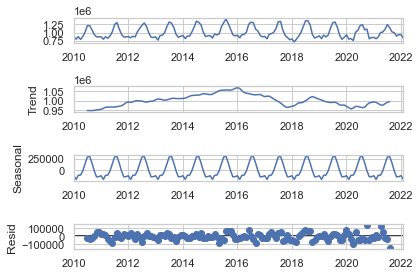

In [122]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data_bca = seasonal_decompose(df_bca, model="additive")
decompose_data_bca.plot();

Separamos la estacionalidad para verla de manera más clara.

<AxesSubplot:xlabel='fecha'>

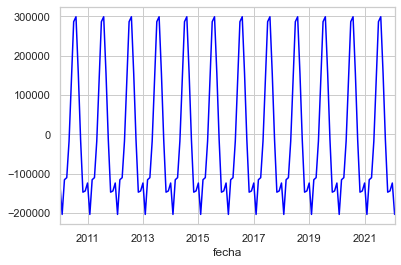

In [123]:
## Graficamos la estacionalidad de nuestros datos.
seasonality_bca=decompose_data_bca.seasonal
seasonality_bca.plot(color='blue')

Ahora podemos notar claramente la estacionalidad que tiene nuestra serie de tiempo. 

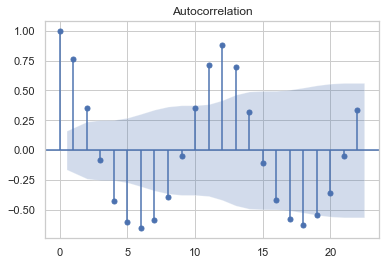

In [124]:
 from statsmodels.graphics.tsaplots import plot_acf
 plot_acf(df_bca); 

Para aplicar un modelo ARIMA a nuestra serie de tiempo, necesitamos que sea una serie estacionaria. Como podemos saber si es estacionaria o no estacionaria? aplicando un ADFuller test, que lo que hace es; hace un test basado en hipotesis, donde si el valor de p-value es menor a 0.05, consideramos que es estacionaria, si es mayor a 0.05 la consideramos no estacionaria.

In [181]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df_bca.bca, autolag = 'AIC')
print("1. ADF : ", dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.9535839594319149
2. P-Value :  0.30728813777795383
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 133
5. Critical Values :
	 1% :  -3.480500383888377
	 5% :  -2.8835279559405045
	 10% :  -2.578495716547007


Aplicando el ADFuller test, vemos que nuestro dataset tiene un p-value de 0.3072, podemos decir que la evidencia a la hipotesis nula es baja, por lo tanto se considera no estacionaria.

Partiendo de esto, tenemos dos opciones: hacer los datos estacionarios o implementar un modelo SARIMAX.

Los modelos SARIMAX (Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors) mantienen el patrón de comportamiento de la estacionalidad. En una serie de tiempo como lo es la generación/demanda de energía, resultan muchos factores como el clima (lluvias, vientos, cambios bruscos de temperatura, etc.), disparos de las maquinas generadoras, confiabilidad de la red, que pueden afectar a su pronóstico, no se pueden medir con exactitud si no se presentan de manera cíclica o con comportamiento estacional.

Veámos como se comporta este modelo en nuestro dataset.

In [126]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df_bca['bca'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

c:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<AxesSubplot:xlabel='fecha'>

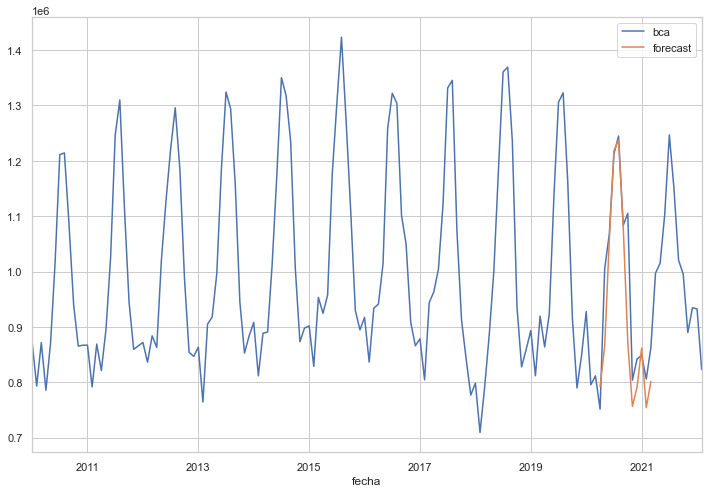

In [127]:
df_bca['forecast']=results.predict(start=123,end=134,dynamic=True)
df_bca[['bca', 'forecast']].plot(figsize=(12,8))

Se puede notar que la implementación del modelo SARIMAX se ajusta muy bien a los datos reales, las lineas de 'forecast' y 'bca' estan practicamente sobrepuestas. 

Lo siguiente es hacer un DataFrame con fechas posteriores a las que tenemos en nuestro dataset, para ajustar los resultados de nuestro modelo a estas fechas.

In [128]:
from pandas.tseries.offsets import DateOffset
pred_date=[df_bca.index[-1]+ DateOffset(months=x)for x in range(0,24)]

pred_date=pd.DataFrame(index=pred_date[1:],columns=df_bca.columns)
pred_date.head()

,bca,forecast
2022-03-01,NaN,NaN
2022-04-01,NaN,NaN
2022-05-01,NaN,NaN
2022-06-01,NaN,NaN
2022-07-01,NaN,NaN


Hacemos un .concat() para unir nuestros DataFrames.

In [129]:
df_bca_=pd.concat([df_bca,pred_date])
df_bca_.head()

,bca,forecast
2010-01-01,873193.999,NaN
2010-02-01,793243.355,NaN
2010-03-01,871591.088,NaN
2010-04-01,785727.001,NaN
2010-05-01,870490.271,NaN


Graficamos nuestro nuevo dataset volviendo a hacer .predict() ajustando el start y end para que se ajuste a las fechas nuevas de predicción.

<AxesSubplot:>

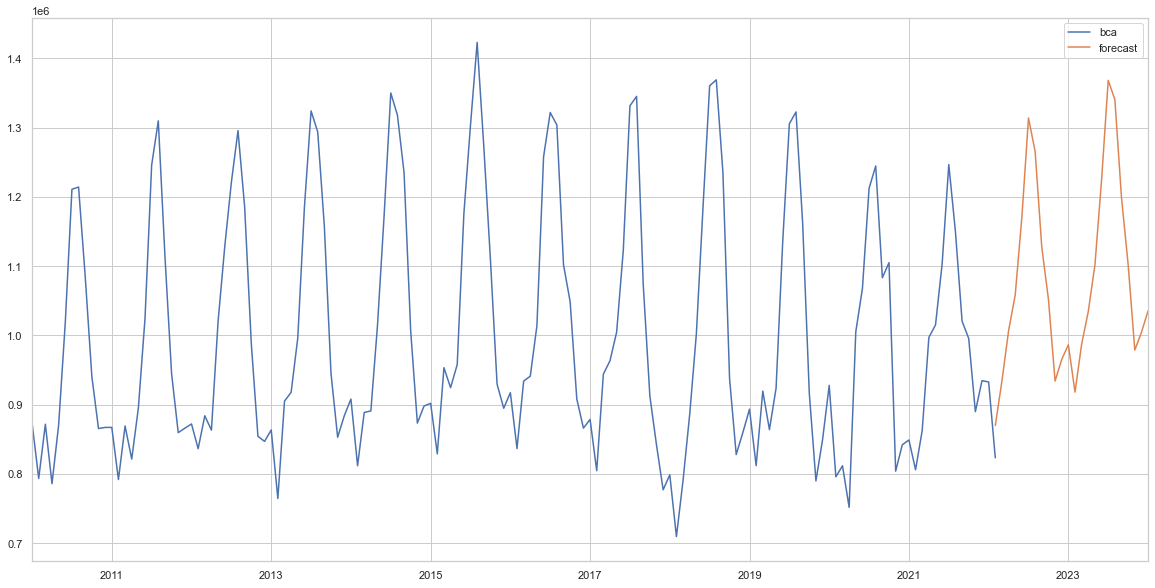

In [130]:
df_bca_['forecast'] = results.predict(start = 145, end = 168, dynamic= True)  
df_bca_
df_bca_[['bca','forecast']].plot(figsize=(20,10))

## SISTEMA ELECTRICO DE BAJA CALIFORNIA SUR (BCS)
# Predicción de Generación Eléctrica

Repetimos los pasos anteriores.

In [136]:
df_bcs = df.drop(columns = ['sin', 'bca'])
df_bcs = df_bcs.set_index(['fecha'])

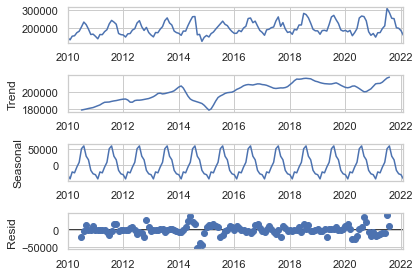

In [137]:
decompose_data_bcs = seasonal_decompose(df_bcs, model="additive")
decompose_data_bcs.plot();

<AxesSubplot:xlabel='fecha'>

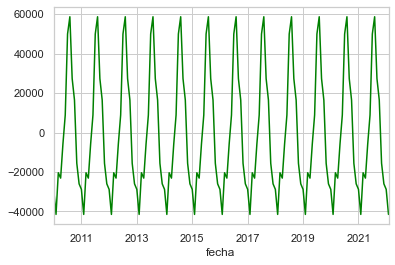

In [138]:
seasonality_bcs=decompose_data_bcs.seasonal
seasonality_bcs.plot(color='green')

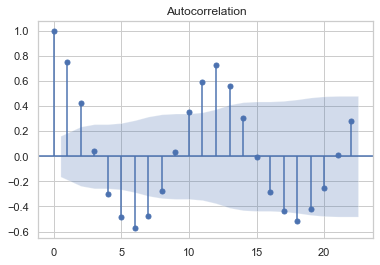

In [139]:
 plot_acf(df_bcs); 

In [184]:
from statsmodels.tsa.stattools import adfuller
dftest_bcs = adfuller(df_bcs.bcs, autolag = 'AIC')
print("1. ADF : ", dftest_bcs[0])
print("2. P-Value : ", dftest_bcs[1])
print("3. Num Of Lags : ", dftest_bcs[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest_bcs[3])
print("5. Critical Values :")
for key, val in dftest_bcs[4].items():
    print("\t",key, ": ", val)

    ## no estacionario, p-value > 0.05

1. ADF :  -1.8084203561565253
2. P-Value :  0.37628930668062266
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 133
5. Critical Values :
	 1% :  -3.480500383888377
	 5% :  -2.8835279559405045
	 10% :  -2.578495716547007


In [183]:
model=sm.tsa.statespace.SARIMAX(df_bcs['bcs'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

c:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



<AxesSubplot:xlabel='fecha'>

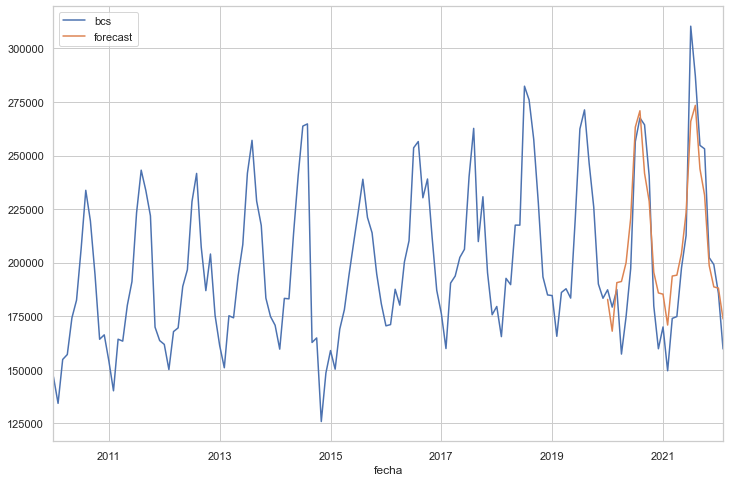

In [142]:
df_bcs['forecast']=results.predict(start=120,end=146,dynamic=True)
df_bcs[['bcs', 'forecast']].plot(figsize=(12,8))

In [143]:
from pandas.tseries.offsets import DateOffset
pred_date_bcs=[df_bca.index[-1]+ DateOffset(months=x)for x in range(0,24)]

pred_date_bcs=pd.DataFrame(index=pred_date_bcs[1:],columns=df_bcs.columns)
pred_date_bcs.head()

,bcs,forecast
2022-03-01,NaN,NaN
2022-04-01,NaN,NaN
2022-05-01,NaN,NaN
2022-06-01,NaN,NaN
2022-07-01,NaN,NaN


In [144]:
df_bcs_=pd.concat([df_bcs,pred_date_bcs])
df_bcs_.head()

,bcs,forecast
2010-01-01,146750.596,NaN
2010-02-01,134343.163,NaN
2010-03-01,154825.632,NaN
2010-04-01,157132.166,NaN
2010-05-01,174237.376,NaN


<AxesSubplot:>

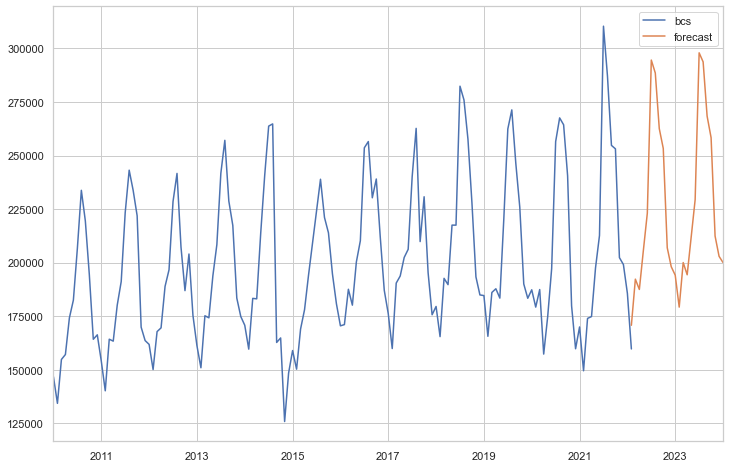

In [145]:
df_bcs_['forecast'] = results.predict(start = 145, end = 168, dynamic= True)  
df_bcs_[['bcs','forecast']].plot(figsize=(12,8))

## SISTEMA INTERCONECTADO NACIONAL (SIN)
# Predicción de Generación Eléctrica

In [187]:
df_sin = df.drop(columns = ['bca', 'bcs'])
df_sin = df_sin.set_index(['fecha'])

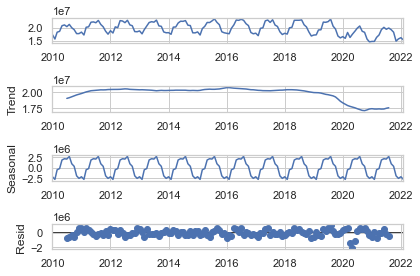

In [188]:
decompose_data_sin = seasonal_decompose(df_sin, model="additive")
decompose_data_sin.plot();

<AxesSubplot:xlabel='fecha'>

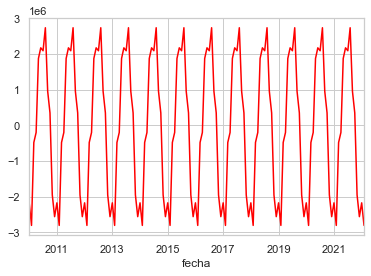

In [189]:
seasonality_sin=decompose_data_sin.seasonal
seasonality_sin.plot(color='red')

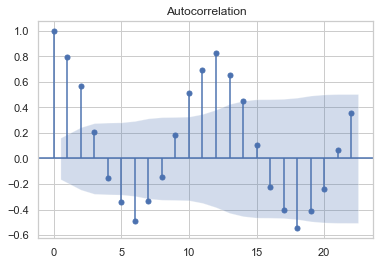

In [190]:
 plot_acf(df_sin); 

In [191]:
from statsmodels.tsa.stattools import adfuller
dftest_sin = adfuller(df_sin.sin, autolag = 'AIC')
print("1. ADF : ", dftest_sin[0])
print("2. P-Value : ", dftest_sin[1])
print("3. Num Of Lags : ", dftest_sin[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest_sin[3])
print("5. Critical Values :")
for key, val in dftest_sin[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.0084528136249682
2. P-Value :  0.7501688599982359
3. Num Of Lags :  14
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 131
5. Critical Values :
	 1% :  -3.481281802271349
	 5% :  -2.883867891664528
	 10% :  -2.5786771965503177


In [192]:
model=sm.tsa.statespace.SARIMAX(df_sin['sin'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

c:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



<AxesSubplot:xlabel='fecha'>

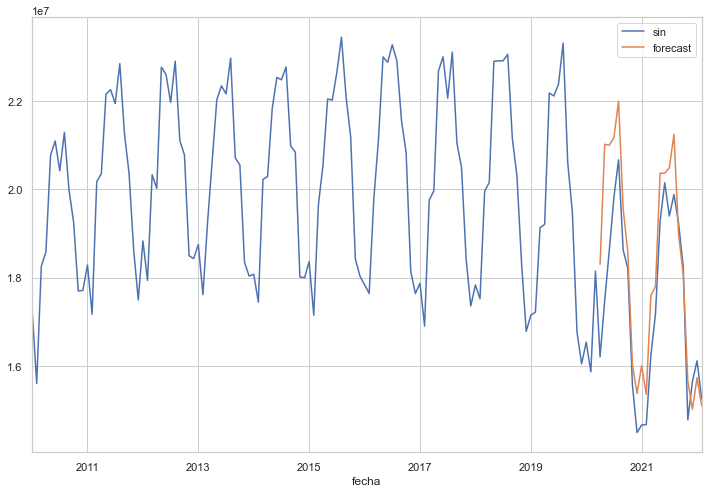

In [193]:
df_sin['forecast']=results.predict(start=123,end=145,dynamic=True)
df_sin[['sin', 'forecast']].plot(figsize=(12,8))

In [194]:
pred_date_sin=[df_sin.index[-1]+ DateOffset(months=x)for x in range(0,24)]

pred_date_sin=pd.DataFrame(index=pred_date_sin[1:],columns=df_sin.columns)
pred_date_sin.head()

,sin,forecast
2022-03-01,NaN,NaN
2022-04-01,NaN,NaN
2022-05-01,NaN,NaN
2022-06-01,NaN,NaN
2022-07-01,NaN,NaN


In [195]:
df_sin_=pd.concat([df_sin,pred_date_sin])
df_sin_.head()

,sin,forecast
2010-01-01,17290950.83,NaN
2010-02-01,15602656.31,NaN
2010-03-01,18255692.77,NaN
2010-04-01,18585459.93,NaN
2010-05-01,20768787.08,NaN


<AxesSubplot:>

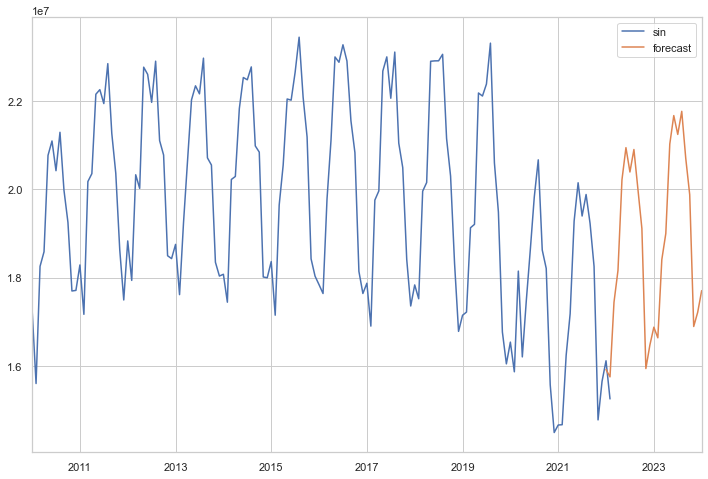

In [196]:
df_sin_['forecast'] = results.predict(start = 144, end = 168, dynamic= True)  
df_sin_[['sin','forecast']].plot(figsize=(12,8))